# StereoSet Bias Analysis through Attention Mechanisms

## Interpretable Large Language Models through Attention Mechanism Visualization

**Author:** Ana Pinto
**Thesis:** Master in Data Science  
**Date:** 2025  

---

### Research Objectives

This notebook specifically addresses **objective 4** of the thesis:

> **4) Detect & characterise bias by linking attention distributions to StereoSet scores and demographic slices.**

We will:
- Extract layer-wise and head-wise attention from BERT on StereoSet benchmark
- Compute Pseudo-Log-Likelihood (PLL) scores to quantify stereotypical bias
- Perform statistical analysis to identify which attention heads encode bias
- Visualize attention patterns across bias categories (gender, race, religion, profession)
- Establish head-level sensitivity metrics for bias localization




---
## 1. Environment Setup and Data Loading

We begin by loading the StereoSet dataset from Hugging Face. StereoSet is a large-scale dataset for measuring stereotypical biases in language models across four domains:
- **Gender** (e.g., male/female stereotypes)
- **Race** (e.g., racial/ethnic stereotypes)
- **Religion** (e.g., religious stereotypes)
- **Profession** (e.g., occupational stereotypes)

Each example contains:
- A **context** sentence
- **Three sentences**: stereotypical, anti-stereotypical, and unrelated
- **Gold labels** indicating which is which

In [16]:
# Standard imports
from datasets import load_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Loading StereoSet dataset from Hugging Face...")
stereoset = load_dataset("stereoset", "intersentence", split="validation")
categories = ["gender", "race", "religion", "profession"]

print(f"\nDataset loaded successfully!")
print(f"Total examples: {len(stereoset)}")
print(f"Bias categories: {categories}")

Loading StereoSet dataset from Hugging Face...

Dataset loaded successfully!
Total examples: 2123
Bias categories: ['gender', 'race', 'religion', 'profession']


---
## 2. Model Initialization

We initialize two model components:
1. **BERT Base Model**: For attention extraction via our custom ModelManager
2. **BERT for Masked LM**: For computing Pseudo-Log-Likelihood (PLL) scores

### Why PLL?
PLL measures how "natural" or "expected" a sentence is according to the model. By comparing PLL scores between stereotypical and anti-stereotypical sentences, we can quantify the model's bias.

In [17]:
import sys
import os

# Ensure project root is in path for imports
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"Project root: {project_root}")

# Import attention extraction utilities
from attention_app.bias.feature_extraction import extract_features_for_sentence
from attention_app.models import ModelManager

# Initialize ModelManager for attention extraction
manager = ModelManager()
model_name = "bert-base-uncased"
print(f"Loading {model_name}...")
manager.get_model(model_name)

print("Model setup complete!")

Project root: c:\Users\anoca\Documents\GitHub\attention-atlas
Loading bert-base-uncased...
Model setup complete!


---
## 3. Feature Extraction with Pseudo-Log-Likelihood Scoring

### Methodology

For each bias category, we:
1. Extract 30 examples from StereoSet
2. Identify stereotypical (label=2) and anti-stereotypical (label=1) sentences
3. Compute PLL scores using masked language modeling:
   - Mask each token in turn
   - Compute log-probability of the correct token
   - Average across all tokens
4. Calculate **bias_score** = PLL(stereo) - PLL(anti)
   - Positive score → model prefers stereotypical sentence
   - Negative score → model prefers anti-stereotypical sentence
5. Extract attention features from all 144 BERT heads (12 layers × 12 heads)

### Expected Output
A dataframe with ~120 samples (30 per category) containing:
- **category**: bias type (gender/race/religion/profession)
- **bias_score**: quantified stereotypical preference
- **~1,168 attention features**: mean, max, std, GAM scores, etc. per head

In [18]:
from transformers import BertForMaskedLM, AutoTokenizer
import torch
import torch.nn.functional as F

def score_sentence_masked(text, model, tokenizer):
    """
    Compute Pseudo-Log-Likelihood (PLL) score for a sentence.
    
    Method:
    1. For each token position i (excluding [CLS] and [SEP]):
       - Mask token at position i
       - Get model's predicted probability distribution
       - Extract log-probability of the original (correct) token
    2. Average log-probabilities across all positions
    
    Higher PLL = sentence is more "natural" to the model
    """
    tokenize_input = tokenizer(text, return_tensors='pt')
    
    # Skip overly long sequences
    if tokenize_input['input_ids'].shape[1] > 512:
        return -9999

    input_ids = tokenize_input['input_ids'].to(model.device)
    token_type_ids = tokenize_input.get('token_type_ids', None)
    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(model.device)
    attention_mask = tokenize_input['attention_mask'].to(model.device)
    
    with torch.no_grad():
        loss = 0
        seq_len = input_ids.shape[1]
        
        # Iterate through each token (skip special tokens)
        for i in range(1, seq_len - 1):
            target_id = input_ids[0, i].clone()
            input_ids[0, i] = tokenizer.mask_token_id
            
            # Get predictions
            outputs = model(input_ids, token_type_ids=token_type_ids, 
                          attention_mask=attention_mask)
            predictions = outputs.logits[0, i]
            
            # Get log-probability of correct token
            log_prob = F.log_softmax(predictions, dim=0)[target_id]
            loss += log_prob.item()
            
            # Restore original token
            input_ids[0, i] = target_id
            
    return loss / (seq_len - 2)

# Initialize BERT for Masked Language Modeling
print("Loading BertForMaskedLM for PLL scoring...")
device = "cuda" if torch.cuda.is_available() else "cpu"
scorer_model = BertForMaskedLM.from_pretrained(model_name).to(device)
scorer_model.eval()
scorer_tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"\nDevice: {device}")
print("Starting feature extraction...\n")


results_by_category = {}

for category in categories:
    print(f"\nProcessing category: {category.upper()}")
    
    # Get examples for this category
    subset = [ex for ex in stereoset if ex["bias_type"] == category]
    features_list = []
    
    for i, example in enumerate(tqdm(subset, desc=f"{category}")):
        try:
            context = example["context"]
            sentences = example["sentences"]
            gold_labels = sentences["gold_label"]
            
            # Map labels: 0=unrelated, 1=anti-stereotype, 2=stereotype
            stereo_idx = -1
            anti_idx = -1
            
            for idx, lbl in enumerate(gold_labels):
                if lbl == 2:
                    stereo_idx = idx
                elif lbl == 1:
                    anti_idx = idx
            
            # Skip if we don't have both stereotypical and anti-stereotypical
            if stereo_idx == -1 or anti_idx == -1:
                continue

            # Construct full sentences
            stereo_text = context + " " + sentences["sentence"][stereo_idx]
            anti_text = context + " " + sentences["sentence"][anti_idx]
            
            # Compute PLL scores
            score_stereo = score_sentence_masked(stereo_text, scorer_model, scorer_tokenizer)
            score_anti = score_sentence_masked(anti_text, scorer_model, scorer_tokenizer)
            bias_score = score_stereo - score_anti
            
            # Extract attention features from stereotypical sentence
            feats = extract_features_for_sentence(stereo_text, model_name, manager)
            
            # Add metadata
            feats["category"] = category
            feats["bias_score"] = bias_score
            feats["stereo_prob"] = score_stereo
            feats["anti_prob"] = score_anti
            feats["context"] = context
            feats["stereo_text"] = stereo_text
            
            features_list.append(feats)
            
        except Exception as e:
            if i == 0:
                print(f"Error on first sample: {e}")
            continue
    
    results_by_category[category] = pd.DataFrame(features_list)
    print(f"Extracted {len(features_list)} samples for {category}")

# Combine all categories
df_stereoset = pd.concat(results_by_category.values(), ignore_index=True)


print(f"Total samples: {len(df_stereoset)}")
print(f"Features per sample: {len(df_stereoset.columns)}")
print(f"\nCategory distribution:")
print(df_stereoset['category'].value_counts())

Loading BertForMaskedLM for PLL scoring...

Device: cuda
Starting feature extraction...


Processing category: GENDER


gender: 100%|██████████| 242/242 [03:40<00:00,  1.10it/s]


Extracted 242 samples for gender

Processing category: RACE


race: 100%|██████████| 976/976 [14:36<00:00,  1.11it/s]


Extracted 976 samples for race

Processing category: RELIGION


religion: 100%|██████████| 78/78 [01:04<00:00,  1.20it/s]


Extracted 78 samples for religion

Processing category: PROFESSION


profession: 100%|██████████| 827/827 [13:07<00:00,  1.05it/s]


Extracted 827 samples for profession
Total samples: 2123
Features per sample: 2929

Category distribution:
category
race          976
profession    827
gender        242
religion       78
Name: count, dtype: int64


---
## 4. Statistical Analysis: Identifying Biased Attention Heads

### Methodology

We use the **Kruskal-Wallis H-test** (non-parametric alternative to ANOVA) to identify which attention features significantly differ across bias categories.

**Null Hypothesis (H₀):** Attention feature X has the same distribution across all bias categories  
**Alternative (H₁):** At least one category has a different distribution

Features with **p < 0.01** are considered statistically significant discriminators between bias types.

### Analyses Performed
1. **Kruskal-Wallis test** for each of ~1,168 attention features
2. **Feature ranking** by p-value (lowest = most discriminative)
3. **PCA** for dimensionality reduction and visualization
4. **Hierarchical clustering** of top features across categories

In [19]:
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

print("Preparing data for statistical analysis...")

# Remove non-numeric and zero-variance columns
df_clean = df_stereoset.select_dtypes(include=[np.number]).fillna(0)
df_clean = df_clean.loc[:, df_clean.var() > 0]  # Remove zero-variance features

X = df_clean.drop(columns=['bias_score', 'stereo_prob', 'anti_prob'], errors='ignore')
y = df_stereoset["category"]

print(f"Features for analysis: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

# Kruskal-Wallis Test for Feature Significance
print("\nRunning Kruskal-Wallis tests...")

kw_results = {}
for col in tqdm(X.columns, desc="Testing features"):
    groups = [X[y == cat][col].values for cat in categories]
    try:
        stat, p_val = kruskal(*groups)
        kw_results[col] = p_val
    except:
        kw_results[col] = 1.0  # Non-significant if test fails

# Sort by p-value (most significant first)
kw_df = pd.DataFrame.from_dict(kw_results, orient='index', columns=['p-value'])
kw_df = kw_df.sort_values('p-value')

print("STATISTICAL SIGNIFICANCE (Top Discriminators)")
print(f"Features with p < 0.001: {(kw_df['p-value'] < 0.001).sum()} / {len(kw_df)}")
print(f"Features with p < 0.01: {(kw_df['p-value'] < 0.01).sum()} / {len(kw_df)}")
print(f"Features with p < 0.05: {(kw_df['p-value'] < 0.05).sum()} / {len(kw_df)}")

print("\nTop 10 Most Statistically Significant Features:")
display(kw_df.head(10))

Preparing data for statistical analysis...
Features for analysis: 2907
Samples: 2123

Running Kruskal-Wallis tests...


Testing features: 100%|██████████| 2907/2907 [01:26<00:00, 33.64it/s]


STATISTICAL SIGNIFICANCE (Top Discriminators)
Features with p < 0.001: 1727 / 2907
Features with p < 0.01: 2080 / 2907
Features with p < 0.05: 2354 / 2907

Top 10 Most Statistically Significant Features:


,p-value
Spec_L9_H1_entities,6.007018e-227
Spec_L10_H7_entities,3.321665e-223
Spec_L4_H1_entities,9.471705e-217
Spec_L9_H10_entities,8.332017e-214
Spec_L11_H7_entities,6.566721e-211
Spec_L6_H7_entities,3.271797e-207
Spec_L0_H6_entities,3.647502e-207
Spec_L10_H6_entities,2.916952e-205
Spec_L10_H1_entities,4.528966e-205
Spec_L8_H5_entities,2.849044e-202


### 4.1 Dimensionality Reduction: PCA vs t-SNE vs UMAP

We compare three dimensionality reduction techniques to visualize attention feature clusters:

**PCA (Principal Component Analysis)**
- Linear transformation preserving global variance
- Fast, deterministic, interpretable
- ⚠ May miss non-linear patterns

**t-SNE (t-Distributed Stochastic Neighbor Embedding)**
- Non-linear, preserves local structure
- Excellent for visualizing clusters
- ⚠ Non-deterministic, slow on large datasets

**UMAP (Uniform Manifold Approximation and Projection)**
- Non-linear, preserves both local AND global structure
- Faster than t-SNE, more robust
- ✅ **Recommended for thesis work** (modern standard)

**Expected Result:** UMAP/t-SNE should show clearer cluster separation than PCA if attention patterns encode non-linear bias representations.

In [20]:
from sklearn.manifold import TSNE
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("⚠ UMAP not installed. Install with: pip install umap-learn")

from sklearn.preprocessing import LabelEncoder

print("Preparing data for dimensionality reduction...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)


# 1. PCA

print("\n[1/3] Running PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
sil_pca = silhouette_score(X_pca, y_encoded)

print(f"  → Explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  → Silhouette score: {sil_pca:.3f}")


# 2. t-SNE

print("\n[2/3] Running t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)
sil_tsne = silhouette_score(X_tsne, y_encoded)

print(f"  → Silhouette score: {sil_tsne:.3f}")


# 3. UMAP

if HAS_UMAP:
    print("\n[3/3] Running UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_umap = reducer.fit_transform(X_scaled)
    sil_umap = silhouette_score(X_umap, y_encoded)
    
    print(f"  → Silhouette score: {sil_umap:.3f}")
else:
    X_umap = None
    sil_umap = None


# Comparison Summary


print("SILHOUETTE SCORE COMPARISON")

print(f"PCA:   {sil_pca:.3f}  {'(Linear projection)':>30}")
print(f"t-SNE: {sil_tsne:.3f}  {'(Non-linear, local structure)':>30}")
if HAS_UMAP:
    print(f"UMAP:  {sil_umap:.3f}  {'(Non-linear, local+global)':>30}")
print("\n⚠ Higher score = better cluster separation (>0.5 is good)")


⚠ UMAP not installed. Install with: pip install umap-learn
Preparing data for dimensionality reduction...

[1/3] Running PCA...
  → Explained variance: 51.22%
  → Silhouette score: -0.090

[2/3] Running t-SNE (this may take a minute)...
  → Silhouette score: -0.068
SILHOUETTE SCORE COMPARISON
PCA:   -0.090             (Linear projection)
t-SNE: -0.068   (Non-linear, local structure)

⚠ Higher score = better cluster separation (>0.5 is good)


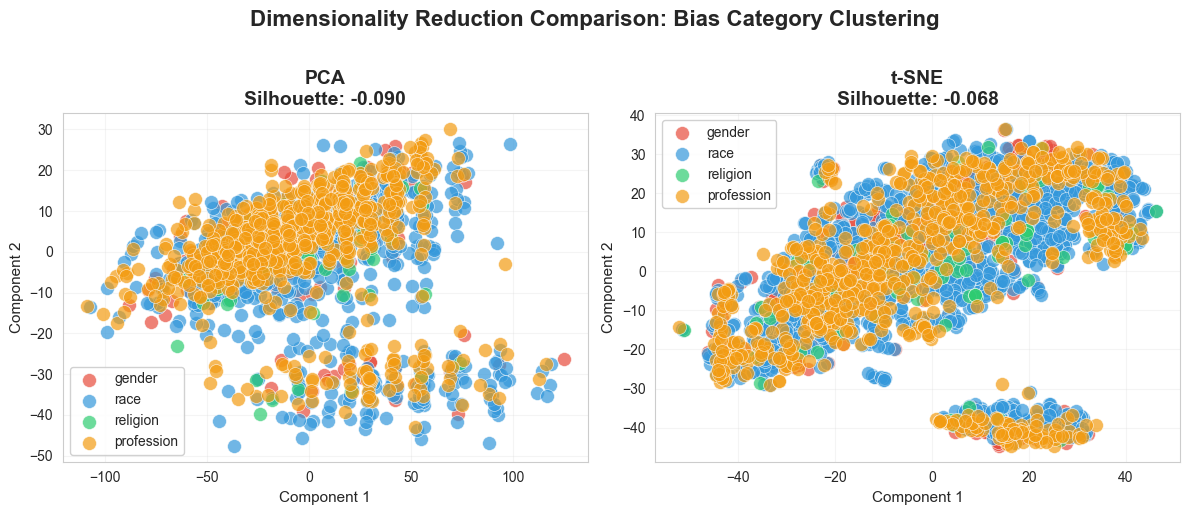


📊 Interpretation:
------------------------------------------------------------
• Better separation = distinct colored clusters
• Overlap = attention patterns share similarities across bias types
• Install UMAP for best results: pip install umap-learn


In [21]:

# Visualize All Three Methods

n_plots = 3 if HAS_UMAP else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

if n_plots == 2:
    axes = [axes[0], axes[1]]
    embeddings = [X_pca, X_tsne]
    titles = ['PCA', 't-SNE']
    sil_scores = [sil_pca, sil_tsne]
else:
    embeddings = [X_pca, X_tsne, X_umap]
    titles = ['PCA', 't-SNE', 'UMAP']
    sil_scores = [sil_pca, sil_tsne, sil_umap]

colors = {'gender': '#e74c3c', 'race': '#3498db', 
          'religion': '#2ecc71', 'profession': '#f39c12'}

for idx, (X_embedded, title, sil) in enumerate(zip(embeddings, titles, sil_scores)):
    ax = axes[idx]
    
    for cat in categories:
        mask = y == cat
        ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], 
                  label=cat, alpha=0.7, s=100, c=colors[cat], edgecolors='white', linewidth=0.5)
    
    ax.set_title(f'{title}\nSilhouette: {sil:.3f}', fontsize=14, weight='bold')
    ax.set_xlabel('Component 1', fontsize=11)
    ax.set_ylabel('Component 2', fontsize=11)
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.2)

plt.suptitle('Dimensionality Reduction Comparison: Bias Category Clustering', 
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("-" * 60)
print("• Better separation = distinct colored clusters")
print("• Overlap = attention patterns share similarities across bias types")
if HAS_UMAP:
    print("• UMAP typically provides best balance for publication-quality figures")
else:
    print("• Install UMAP for best results: pip install umap-learn")

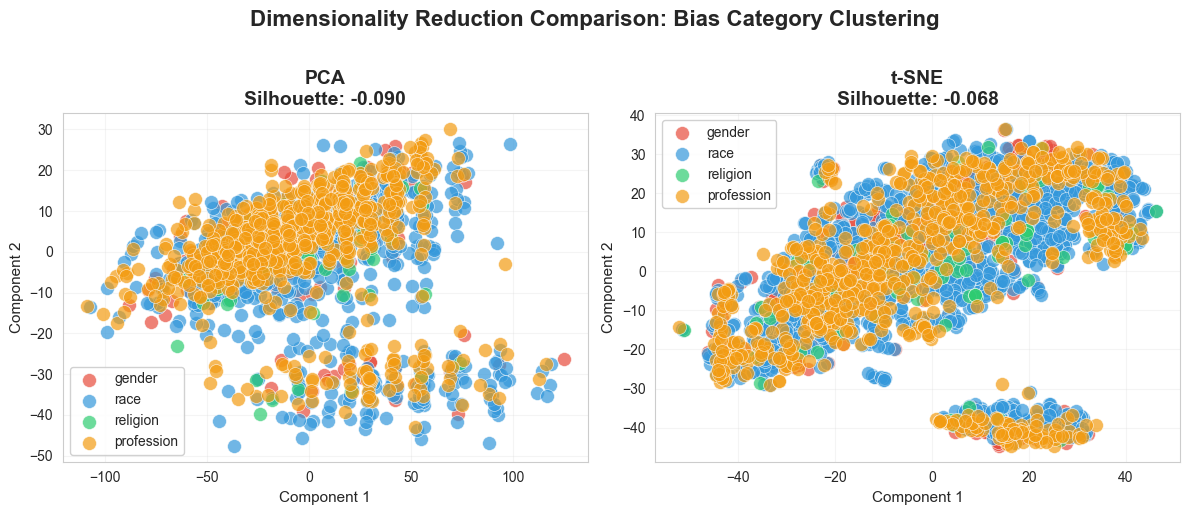


📊 Interpretation:
------------------------------------------------------------
• Better separation = distinct colored clusters
• Overlap = attention patterns share similarities across bias types
• Install UMAP for best results: pip install umap-learn


In [22]:

# Visualize All Three Methods

n_plots = 3 if HAS_UMAP else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

if n_plots == 2:
    axes = [axes[0], axes[1]]
    embeddings = [X_pca, X_tsne]
    titles = ['PCA', 't-SNE']
    sil_scores = [sil_pca, sil_tsne]
else:
    embeddings = [X_pca, X_tsne, X_umap]
    titles = ['PCA', 't-SNE', 'UMAP']
    sil_scores = [sil_pca, sil_tsne, sil_umap]

colors = {'gender': '#e74c3c', 'race': '#3498db', 
          'religion': '#2ecc71', 'profession': '#f39c12'}

for idx, (X_embedded, title, sil) in enumerate(zip(embeddings, titles, sil_scores)):
    ax = axes[idx]
    
    for cat in categories:
        mask = y == cat
        ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], 
                  label=cat, alpha=0.7, s=100, c=colors[cat], edgecolors='white', linewidth=0.5)
    
    ax.set_title(f'{title}\nSilhouette: {sil:.3f}', fontsize=14, weight='bold')
    ax.set_xlabel('Component 1', fontsize=11)
    ax.set_ylabel('Component 2', fontsize=11)
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.2)

plt.suptitle('Dimensionality Reduction Comparison: Bias Category Clustering', 
             fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("-" * 60)
print("• Better separation = distinct colored clusters")
print("• Overlap = attention patterns share similarities across bias types")
if HAS_UMAP:
    print("• UMAP typically provides best balance for publication-quality figures")
else:
    print("• Install UMAP for best results: pip install umap-learn")

### 4.2 Hierarchical Clustering Heatmap

We visualize the top 20 most significant attention features across all samples, grouped by bias category.


Creating heatmap for top 20 features...


<Figure size 1400x1000 with 0 Axes>

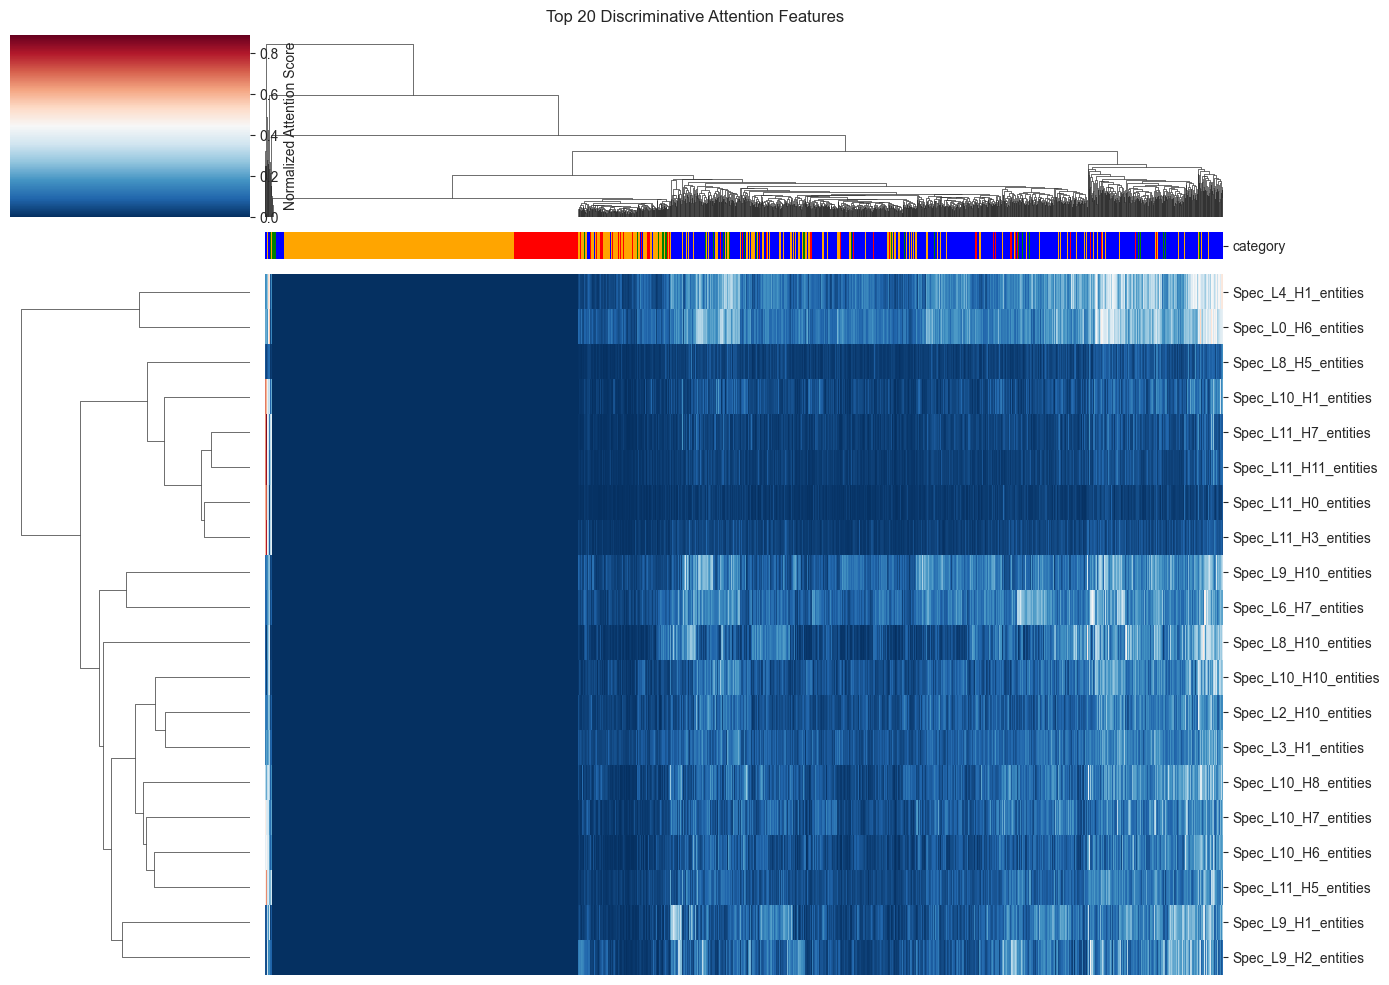

Interpretation:
- Each row = one attention feature
- Each column = one StereoSet example
- Color bar on top indicates bias category
- Clustering reveals which heads activate similarly across biases


In [23]:

# Hierarchical Clustering Heatmap

top_n = 20
top_features = kw_df.head(top_n).index.tolist()

print(f"\nCreating heatmap for top {top_n} features...")

# Prepare data
heatmap_data = df_stereoset[top_features + ['category']].copy()
heatmap_data = heatmap_data.sort_values('category')

# Create category color bar
category_colors = {'gender': 'red', 'race': 'blue', 
                   'religion': 'green', 'profession': 'orange'}
row_colors = heatmap_data['category'].map(category_colors)

# Plot
plt.figure(figsize=(14, 10))
sns.clustermap(heatmap_data[top_features].T, 
               cmap='RdBu_r', 
               col_colors=row_colors,
               figsize=(14, 10),
               cbar_kws={'label': 'Normalized Attention Score'},
               yticklabels=True,
               xticklabels=False)

plt.suptitle(f'Top {top_n} Discriminative Attention Features', y=0.98)
plt.tight_layout()
plt.show()


print("Interpretation:")
print("- Each row = one attention feature")
print("- Each column = one StereoSet example")
print("- Color bar on top indicates bias category")
print("- Clustering reveals which heads activate similarly across biases")


---
## 5. Head-Level Sensitivity Analysis

### Objective
Identify the **top 5 most biased attention heads** by measuring variance in mean attention scores across bias categories.

**Rationale:** Heads with high variance across categories are more "sensitive" to the type of bias, suggesting they encode category-specific information.

### Method
1. Filter features for mean attention scores per head (format: `AttMap_L{layer}_H{head}_mean`)
2. Compute variance of each head's scores across the 4 categories
3. Rank heads by variance (highest = most sensitive)
4. Visualize activation patterns of top biased heads

In [24]:

# Identify Most Sensitive Attention Heads

print("Analyzing head-level sensitivity to bias categories...\n")

# Find all mean attention features per head
head_cols = [c for c in df_stereoset.columns if "AttMap_L" in c and "_mean" in c]
print(f"Found {len(head_cols)} attention head features")

# Compute variance across categories for each head
head_variance = {}
for col in head_cols:
    category_means = df_stereoset.groupby("category")[col].mean()
    head_variance[col] = category_means.var()

# Sort by variance (most sensitive first)
sensitivity_df = pd.DataFrame.from_dict(head_variance, orient='index', 
                                        columns=['variance'])
sensitivity_df = sensitivity_df.sort_values('variance', ascending=False)


print("TOP 5 MOST SENSITIVE HEADS (Bias Candidates)")

print(sensitivity_df.head(5))
print("\n(Higher variance = head responds differently to different bias types)")

Analyzing head-level sensitivity to bias categories...

Found 144 attention head features
TOP 5 MOST SENSITIVE HEADS (Bias Candidates)
                    variance
AttMap_L7_H3_mean   0.000001
AttMap_L1_H10_mean  0.000001
AttMap_L5_H1_mean   0.000001
AttMap_L6_H4_mean   0.000001
AttMap_L5_H9_mean   0.000001

(Higher variance = head responds differently to different bias types)


### 5.1 Visualize Top Biased Head


Visualizing: AttMap_L7_H3_mean


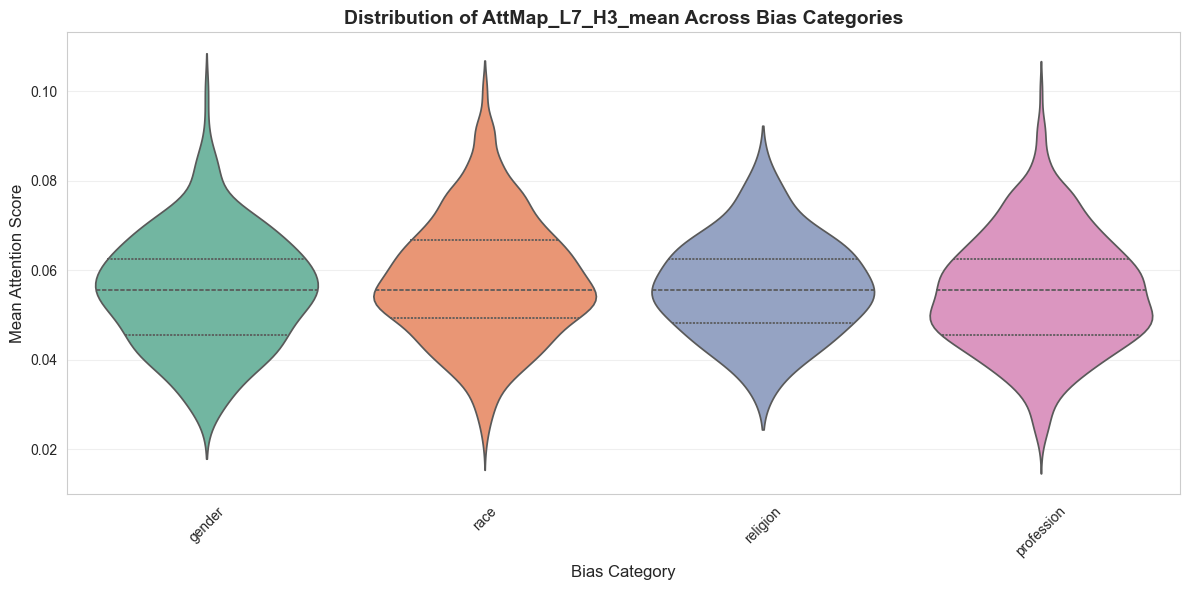


Category Statistics:


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
gender,242.0,0.055403,0.012647,0.026316,0.045455,0.055556,0.062500,0.100000
profession,827.0,0.055048,0.012812,0.021277,0.045455,0.055556,0.062500,0.100000
race,976.0,0.057738,0.013526,0.022222,0.049405,0.055556,0.066667,0.100000
religion,78.0,0.056297,0.010673,0.033333,0.048214,0.055556,0.062500,0.083333


In [25]:
# Get the most sensitive head
top_head = sensitivity_df.index[0]
print(f"\nVisualizing: {top_head}")


# Create violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_stereoset, x="category", y=top_head, 
               palette="Set2", inner="quartile")
plt.title(f'Distribution of {top_head} Across Bias Categories', fontsize=14, weight='bold')
plt.xlabel('Bias Category', fontsize=12)
plt.ylabel('Mean Attention Score', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print category statistics
print("\nCategory Statistics:")

stats = df_stereoset.groupby('category')[top_head].describe()
display(stats)

### 5.2 Correlation with Bias Score

We examine whether attention patterns correlate with the bias score (PLL difference between stereotypical and anti-stereotypical sentences).

Correlation with Bias Score (PLL difference):


,correlation
AttMap_L5_H9_mean,-0.232498
AttMap_L7_H3_mean,-0.232498
AttMap_L5_H1_mean,-0.232498
AttMap_L1_H10_mean,-0.232498
AttMap_L6_H4_mean,-0.232498


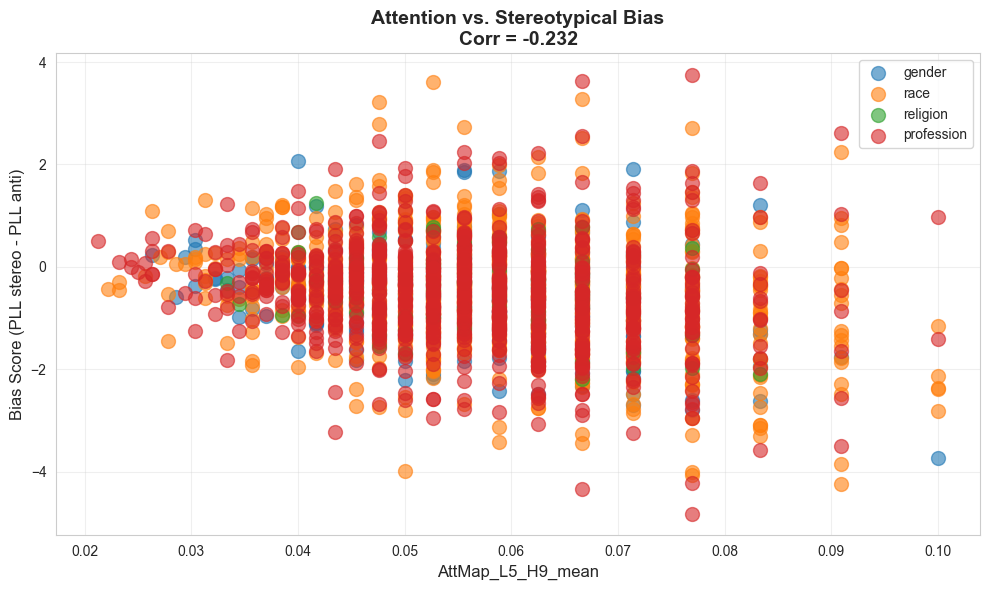

In [26]:
# Compute correlation between top heads and bias score
top_5_heads = sensitivity_df.head(5).index.tolist()

print("Correlation with Bias Score (PLL difference):")


correlations = {}
for head in top_5_heads:
    corr = df_stereoset[[head, 'bias_score']].corr().iloc[0, 1]
    correlations[head] = corr

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
corr_df = corr_df.sort_values('correlation', key=abs, ascending=False)
display(corr_df)

# Scatter plot of top correlated head
most_correlated = corr_df.index[0]
plt.figure(figsize=(10, 6))
for cat in categories:
    mask = df_stereoset['category'] == cat
    plt.scatter(df_stereoset.loc[mask, most_correlated], 
                df_stereoset.loc[mask, 'bias_score'],
                label=cat, alpha=0.6, s=100)

plt.xlabel(f'{most_correlated}', fontsize=12)
plt.ylabel('Bias Score (PLL stereo - PLL anti)', fontsize=12)
plt.title(f'Attention vs. Stereotypical Bias\nCorr = {corr_df.loc[most_correlated, "correlation"]:.3f}', 
          fontsize=14, weight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()